# Goal: 
### To find a flaring area during FOXSI2 observations.

Athiray considered Target1 Pos 2 - 19:13:47 to 19:14:25 for this study, where microflare-1 was mostly on-axis. For variance calculation in Fe18 map use this time interval. Consider the region in the map around microflare-1 say xrange = [-45,105], yrange=[-295,-145]. 


### Packages:

In [1]:
import glob
from sunpy.map import Map
from sunpy.time import TimeRange
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.dates as md
import matplotlib as mpl
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
from matplotlib.colors import ListedColormap
import numpy as np
import ipywidgets as widgets
%matplotlib inline
from ndcube import NDCube, NDCubeSequence
from sunpy import cm

/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### FOXSI2 Targets

In [2]:
Ftarget = {'cen1_pos0':(359.0, -431.0), # arcsec
           'cen1_pos1':(-1.0, -431.0),
           'cen1_pos2':(-1.0, -251.0),
           'cen2_pos0':(-1.0, -281.0),
           'cen2_pos1':(-390.0, -281.0),
           'cen3_pos0':(1210.5, -431.5),
           'cen3_pos1':(850.0, -431.5),
           'cen3_pos2':(850.0, -251.0),
           'cen4':(200.0, 750.0),
           'cen5':(0.0, -251.0),
           'cen_Iris':(11,-260),
           'athiray':(30,-220)}
Ftimes = {'cen1_pos0': TimeRange(['2014-12-11 19:12:42', '2014-12-11 19:13:14.3']),
            'cen1_pos1':TimeRange(['2014-12-11 19:13:18','2014-12-11 19:13:42.6']),
            'cen1_pos2':TimeRange(['2014-12-11 19:13:46.5','2014-12-11 19:14:25']),
            'cen2_pos0':TimeRange(['2014-12-11 19:14:29','2014-12-11 19:14:39.6']),
            'cen2_pos1':TimeRange(['2014-12-11 19:14:44','2014-12-11 19:15:36.7']),
            'cen3_pos0':TimeRange(['2014-12-11 19:15:40.6','2014-12-11 19:16:07.2']),
            'cen3_pos1':TimeRange(['2014-12-11 19:16:11','2014-12-11 19:16:30.1']),
            'cen3_pos2':TimeRange(['2014-12-11 19:16:34','2014-12-11 19:17:09.2']),
            'cen4':TimeRange(['2014-12-11 19:17:13.5','2014-12-11 19:18:46.2']),
            'cen5':TimeRange(['2014-12-11 19:18:50.5','2014-12-11 19:19:23.2']),
            't_shtr':TimeRange(['2014-12-11 19:18:18','2014-12-11 19:18:22']),
            'Iris_Obs':TimeRange(['2014-12-11 19:12:22','2014-12-11 19:39:01'])}
fov = (1000,1000) # arcsec
athirayfov = [150,150] #arcsec

### Reading AIA Data:

In [3]:
data_dir = '/Volumes/Pandora/FOXSI/AIA/'
str_indices = {'94':'', '131':'', '171':'', '193':'', '211':'', '304':'', '335':'', '1600':'', '1700':''}
file_list = {}
for key in str_indices:
    file_list.update({key: glob.glob(data_dir + '*' + key + '*.fits')})
    file_list[key]=sorted(file_list[key])

## FeXVIII Full disk image

In [4]:
fd094 = Map(file_list['94'][70])
fd171 = Map(file_list['171'][70])
fd211 = Map(file_list['211'][70])
fd = Map(file_list['171'][70])
fd.data[:] = fd094.data - fd211.data[:]/120 - fd171.data[:]/450

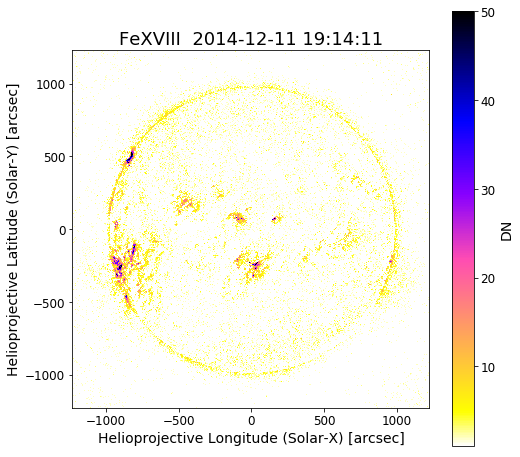

In [5]:
''' Plot '''
fig, ax = plt.subplots(figsize=(8,8));
fd.plot_settings['norm'] = colors.Normalize()
fd.plot(cmap='gnuplot2_r',vmin=1,vmax=50)
plt.title('FeXVIII '+fd.name[-20:],fontsize=18);plt.colorbar(label=fd.meta['pixlunit'])

# Co-rotating data

In [6]:
F_AIA094 = file_list['94']
F_AIA171 = file_list['171']
F_AIA211 = file_list['211']

#F_AIA171 = file_list['171'][52:83]
#F_AIA211 = file_list['211'][56:87]
mapsFe18 = []

for f094, f171, f211 in zip(F_AIA094,F_AIA171,F_AIA211):
    m094  = Map(f094)
    m171  = Map(f171)
    m211  = Map(f211)
    mFe18 = Map(f171)
    mFe18.data[:] = m094.data - m211.data[:]/120 - m171.data[:]/450
    ## Co-rotating maps:
    top_right =   SkyCoord((Ftarget['athiray'][0] + athirayfov[0]/2) * u.arcsec, 
                           (Ftarget['athiray'][1] + athirayfov[1]/2) * u.arcsec, frame=mFe18.coordinate_frame)
    bottom_left = SkyCoord((Ftarget['athiray'][0] - athirayfov[0]/2) * u.arcsec, 
                           (Ftarget['athiray'][1] - athirayfov[1]/2) * u.arcsec,frame=mFe18.coordinate_frame)
    submap = mFe18.submap(bottom_left, top_right)
    mapsFe18.append(submap)    

### FeXVIII Movie

In [7]:
def allfov(t):
#for t in range (68-l,72+l): 
    fig, ax = plt.subplots(figsize=(10,10));
    mapsFe18[t].plot_settings['norm'] = colors.Normalize()
    mapsFe18[t].plot(vmin=10,vmax=200,cmap='gnuplot2_r',title='FeXVIII    '+F_AIA171[t][41:63])
    rect = patches.Rectangle((-45,-295),150,150,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.colorbar()
    #plt.savefig('/Users/Kamilobu/Desktop/temporal/FeXVIII'+str(t)+'.png')

In [8]:
l = 12; 
widgets.interact(allfov, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

### Athiray's Target

In [9]:
def Athirayfov(t):
#for t in range (0,40): ## uncommend this lines for saving the images. 
    fig, ax = plt.subplots(figsize=(10,10));
    mapsFe18[t].plot(vmin=20,vmax=140,cmap='gnuplot2',title='FeXVIII    '+F_AIA171[t][41:63])
    plt.xlim(-45,105)
    plt.ylim(-295,-145)
    plt.colorbar()
    #plt.savefig('Athirayfov/'+str(t)+'.png')

In [10]:
l = 12;
widgets.interact(Athirayfov, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

In [11]:
import copy
diff = copy.deepcopy(mapsFe18)
for d in range (1,len(diff[1:])):
    diff[d].data[:] = mapsFe18[d].data[:] - mapsFe18[d-1].data[:]

In [12]:
def difffov(t):
    fig, ax = plt.subplots(figsize=(10,10));
    diff[t].plot(cmap='gnuplot2',title='FeXVIII    '+F_AIA171[t][41:63],vmin=0)
    rect = patches.Rectangle((-45,-295),150,150,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.colorbar()

In [13]:
l = 12;
widgets.interact(difffov, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

###  Consecutive substractions for Athiray FOV

In [14]:
def difffovAthiray(t):
#for t in range (68-l,72+l): 
    fig, ax = plt.subplots(figsize=(10,10));
    diff[t].plot_settings['norm'] = colors.Normalize()
    diff[t].plot(cmap='gnuplot2_r',title='FeXVIII    '+F_AIA171[t][41:63],vmin=6,vmax=20)
    plt.xlim(-45,105)
    plt.ylim(-295,-145)
    plt.colorbar()
    #plt.savefig('/Users/Kamilobu/Desktop/temporal/FeXVIII'+str(t)+'.png')

In [15]:
l = 12;
widgets.interact(difffovAthiray, t=(68-l,72+l));

interactive(children=(IntSlider(value=70, description='t', max=84, min=56), Output()), _dom_classes=('widget-i…

## Standard Deviation

In [16]:
def std(cmaps):
    """
    Calculate the standard deviation of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.std(data, axis=2), _meta[1])

In [17]:
## Setting Limits:
#maps = []
#for t in range (68-l,72+l):
#    top_right = SkyCoord(105*u.arcsec, -145 * u.arcsec, frame=mapsFe18[t].coordinate_frame)
#    bottom_left = SkyCoord(-45 * u.arcsec, -295 * u.arcsec, frame=mapsFe18[t].coordinate_frame)
#    submap = mapsFe18[t].submap(bottom_left, top_right)
#    maps.append(submap)

## Standard Deviation:
l = 12;
maps = mapsFe18[68-l:72+l]
stdmap = std(maps)

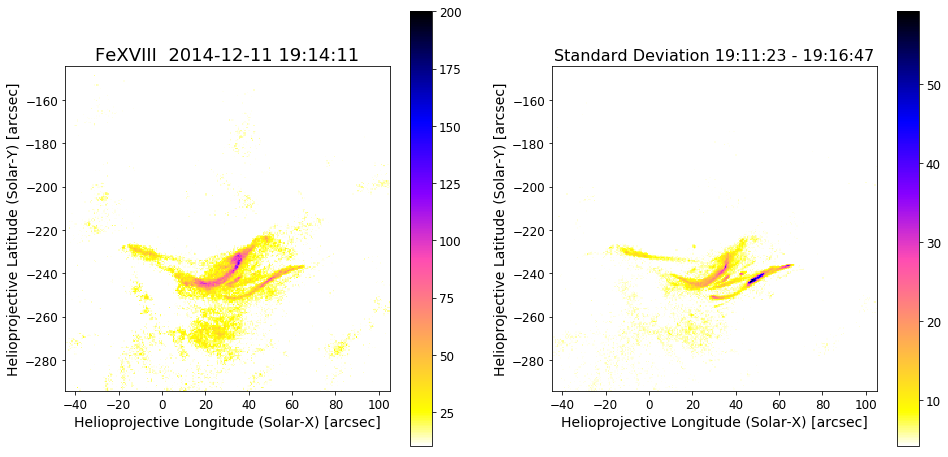

In [18]:
ta = 14
'''Plotting'''
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
maps[ta].plot_settings['norm'] = colors.Normalize()
maps[ta].plot(cmap='gnuplot2_r',vmin=10,vmax=200)
plt.title('FeXVIII '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
plt.subplot(1,2,2)
stdmap.plot_settings['norm'] = colors.Normalize()
stdmap.plot(vmin=0.07*stdmap.data.max(),cmap='gnuplot2_r')
plt.title('Standard Deviation '+maps[0].name[-8:]+' - '+maps[-1].name[-8:],fontsize=16);plt.colorbar()
plt.show()

## Implement Sunpy find bright regions:

In [19]:
from scipy import ndimage
import matplotlib.pyplot as plt
import sunpy.map

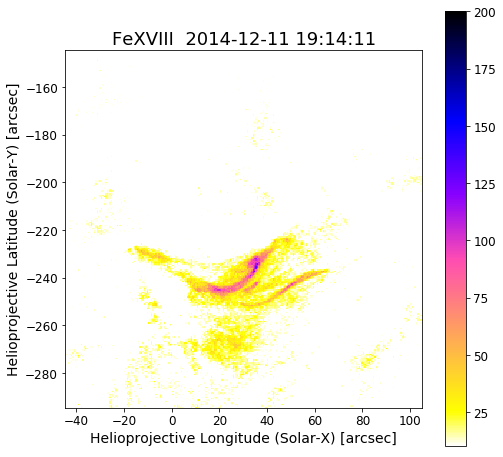

In [20]:
ta = 14
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
maps[ta].plot(cmap='gnuplot2_r',vmin=10,vmax=200)
maps[ta].plot_settings['norm'] = colors.Normalize()
plt.title('FeXVIII '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
plt.show()

### Mask quicklook

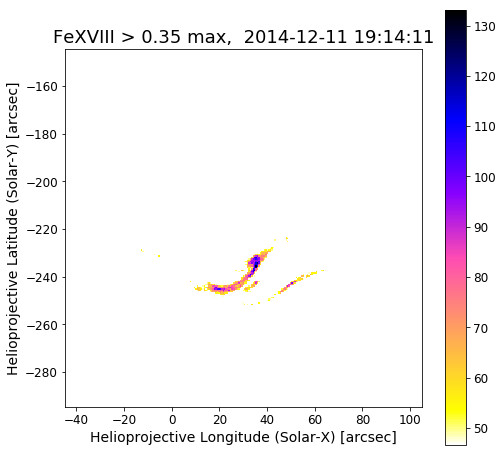

In [21]:
MaskRatio = 0.35
data_max = maps[ta].max()
mask = maps[ta].data > data_max * MaskRatio
#maps[ta].mask = mask
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
maps[ta].plot_settings['norm'] = colors.Normalize()
maps[ta].plot(cmap='gnuplot2_r',vmin=data_max * MaskRatio)
plt.title('FeXVIII > '+str(MaskRatio)+' max, '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
plt.show()

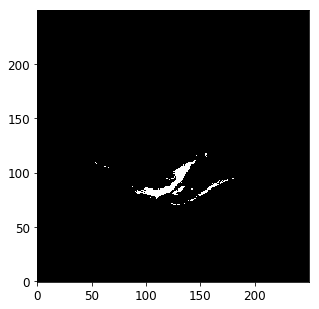

In [22]:
plt.figure(figsize=(5,5))
mask = maps[ta].data < data_max * MaskRatio
plt.imshow(mask,origin='lower',cmap='Greys')

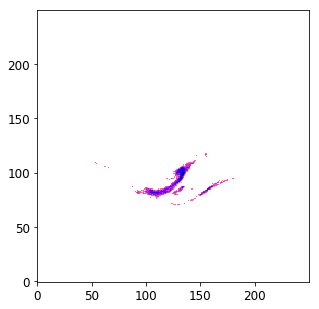

In [23]:
data2 = ndimage.gaussian_filter(maps[ta].data * ~mask, 0)
plt.figure(figsize=(5,5))
plt.imshow(data2,origin='lower',cmap='gnuplot2_r')

### Sunpy regions over the image maximum

In [24]:
data2 = ndimage.gaussian_filter(maps[ta].data * ~mask, 1.5)
aiamap2 = sunpy.map.Map(data2, maps[ta].meta)
labels, n = ndimage.label(aiamap2.data)

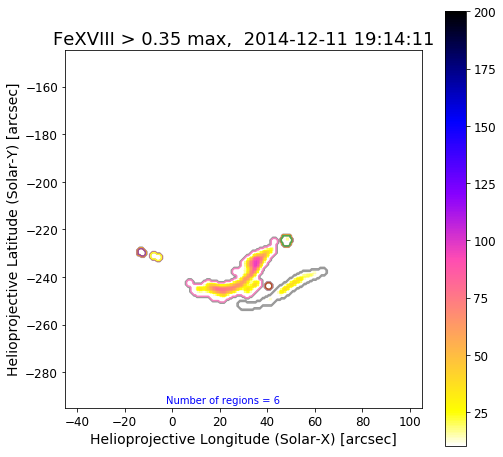

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
aiamap2.plot_settings['norm'] = colors.Normalize()
aiamap2.plot(cmap='gnuplot2_r',vmin=10,vmax=200)
plt.title('FeXVIII > '+str(MaskRatio)+' max, '+maps[ta].name[-20:],fontsize=18);plt.colorbar()
extent = (-45,105,-295,-145)
plt.contour(labels,extent=extent,cmap='Set1_r',vmin=0,vmax=8)
plt.figtext(0.3, 0.2, 'Number of regions = {}'.format(n), color='blue')
plt.show()

### Sunpy kernels with higher variance

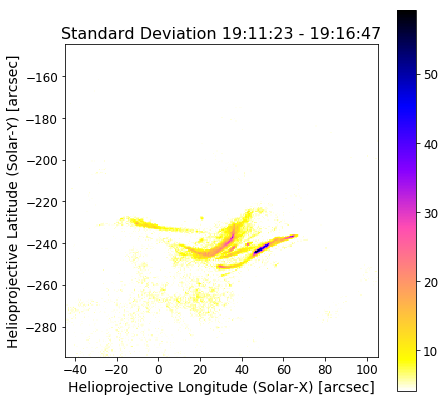

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
stdmap.plot(cmap='gnuplot2_r',vmin=0.07*stdmap.data.max())
plt.title('Standard Deviation '+maps[0].name[-8:]+' - '+maps[-1].name[-8:],fontsize=16);plt.colorbar()
plt.show()

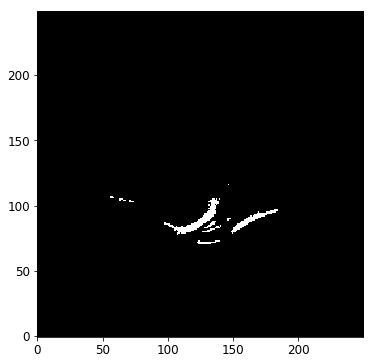

In [27]:
SDMaskRatio = 0.2 ## Porcentage for the mask [Default = 0.4]
SDdata_max = stdmap.max()
SDmask = stdmap.data < SDdata_max * SDMaskRatio
'''plotting'''
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(SDmask,origin='lower',cmap='Greys')
plt.show()

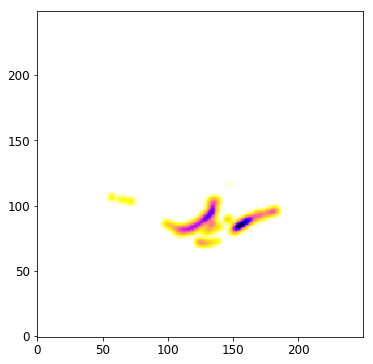

In [28]:
SmoothFactor = 2 ## This is the factor to make a gauss-smooth 1 is no-smooth.
SDdata2 = ndimage.gaussian_filter(stdmap.data * ~SDmask, SmoothFactor)
plt.figure(figsize=(6,6))
plt.imshow(SDdata2,origin='lower',cmap='gnuplot2_r')#vmin=0.07*stdmap.data.max()
plt.show()

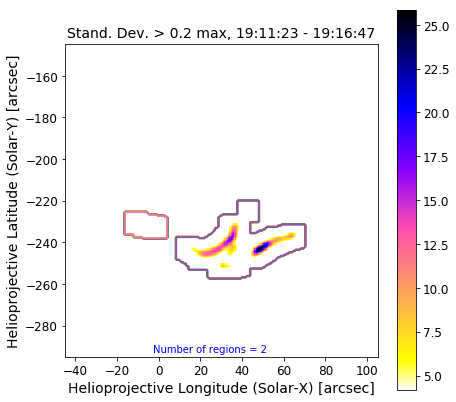

In [29]:
SDmap2 = sunpy.map.Map(SDdata2, stdmap.meta)
SDlabels, SDn = ndimage.label(SDmap2.data)
'''plotting'''
fig, ax = plt.subplots(figsize=(7,7))
SDmap2.plot_settings['norm'] = colors.Normalize()
SDmap2.plot(cmap='gnuplot2_r',vmin=0.07*stdmap.data.max())
plt.title('Stand. Dev. > '+str(SDMaskRatio)+' max, '+maps[0].name[-8:]+' - '+maps[-1].name[-8:],fontsize=14);plt.colorbar()
extent = (-45,105,-295,-145)
plt.contour(SDlabels,extent=extent,cmap='Set1')
plt.figtext(0.3, 0.2, 'Number of regions = {}'.format(SDn), color='blue')
plt.show()

### Light Curves [Maxima in FeXVIII]

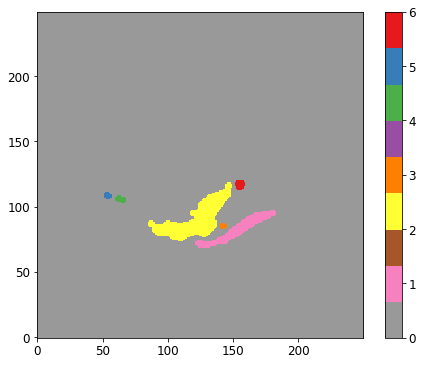

In [30]:
'''Time range'''
atime = []
for m in maps:
    atime.append(str(m.meta['t_obs'][:-1]))
atime = np.array(atime,dtype='datetime64[ms]')
    
atmax = np.array(['2014-12-11T19:13:47','2014-12-11T19:14:25'],dtype='datetime64[ms]')
#atmax = np.array(['2014-12-11T19:13:47','2014-12-11T19:14:25'])
''' Kernels Visualization '''
plt.figure(figsize=(8,6))
plt.imshow(labels,origin='lower',cmap='Set1_r')
plt.colorbar()
plt.show()

#### Individual masks:

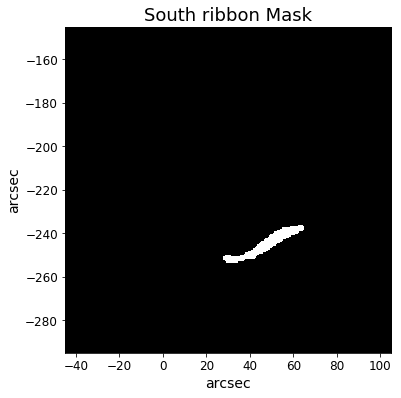

In [31]:
rb1 = (labels==2)
rb2 = (labels==1)
plt.figure(figsize=(8,6))
plt.title('South ribbon Mask',fontsize=18)
plt.imshow(rb2,origin='lower',cmap='Greys_r',extent=extent)
plt.xlabel('arcsec');plt.ylabel('arcsec');
plt.show()

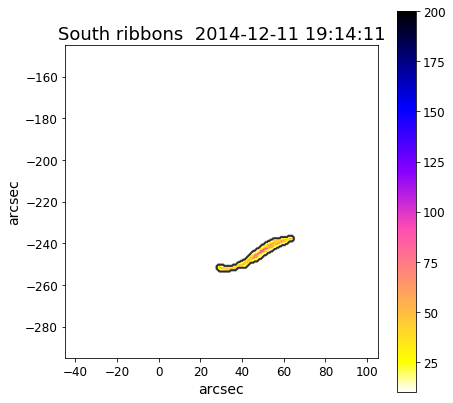

In [32]:
data3 = ndimage.gaussian_filter(maps[ta].data * (rb2), 0)
plt.figure(figsize=(7,7))
extent = (-45,105,-295,-145)
plt.title('South ribbons '+maps[ta].name[-20:],fontsize=18)
plt.imshow(data3,origin='lower',cmap='gnuplot2_r',vmin=10,vmax=200,extent=extent)
plt.colorbar()
plt.xlabel('arcsec');plt.ylabel('arcsec');
plt.contour((rb2),extent=extent,cmap='Greys')

In [33]:
lcrb1,lcrb2,lcrb3 = [],[],[] 
for m in maps:
    lcrb1.append((m.data * (labels == 2)).sum())
    lcrb2.append((m.data * (labels == 1)).sum())
    lcrb3.append((m.data * (labels == 2)).sum()+(m.data * (labels == 1)).sum())

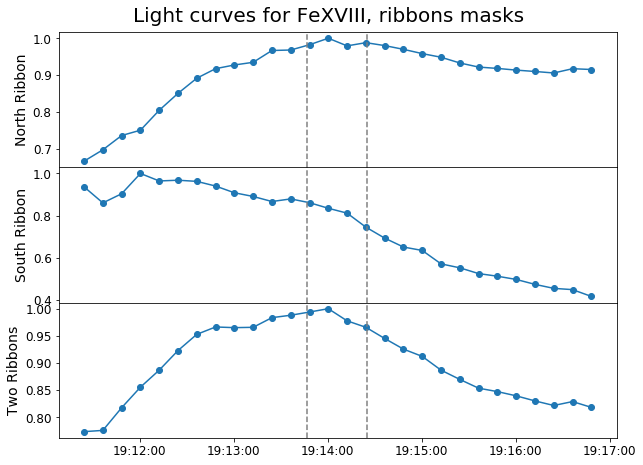

In [44]:
xfmt = md.DateFormatter('%H:%M:%S')
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True,figsize=(10,7))
fig.suptitle('Light curves for FeXVIII, ribbons masks',fontsize=20);fig.subplots_adjust(top=0.93)
ax1.plot(atime,np.abs(lcrb1)/np.abs(max(lcrb1)),'o-')
ax1.axvline(x=atmax[0],linestyle='--',color='grey');ax1.axvline(x=atmax[1],linestyle='--',color='grey')
ax1.set_ylabel('North Ribbon')
ax2.plot(atime,np.abs(lcrb2)/np.abs(max(lcrb2)),'o-')
ax2.axvline(x=atmax[0],linestyle='--',color='grey');ax2.axvline(x=atmax[1],linestyle='--',color='grey')
ax2.set_ylabel('South Ribbon')
ax3.plot(atime,np.abs(lcrb3)/np.abs(max(lcrb3)),'o-')
ax3.axvline(x=atmax[0],linestyle='--',color='grey');ax3.axvline(x=atmax[1],linestyle='--',color='grey')
ax3.set_ylabel('Two Ribbons')
ax3.xaxis.set_major_formatter(xfmt)
fig.subplots_adjust(hspace=0)
plt.show()

In [35]:
print('North Ribbon [pxs] =  '+str(len(labels[labels == 2])))
print('South Ribbon [pxs] =  '+str(len(labels[labels == 1])))
print('Two Ribbons  [pxs] =  '+str(len(labels[labels == 2])+len(labels[labels == 1])))

North Ribbon [pxs] =  1019
South Ribbon [pxs] =  449
Two Ribbons  [pxs] =  1468


In [43]:
import pandas as pd
df = pd.DataFrame({"time" : atime,
                   "North Ribbon" : np.abs(lcrb1)/np.abs(max(lcrb1)),
                   "South Ribbon" : np.abs(lcrb2)/np.abs(max(lcrb2)),
                   "Two Ribbons" : np.abs(lcrb3)/np.abs(max(lcrb3))})
df.to_csv("MicroflareC_FeZVIII.csv", index=False)

##### Standard Deviation

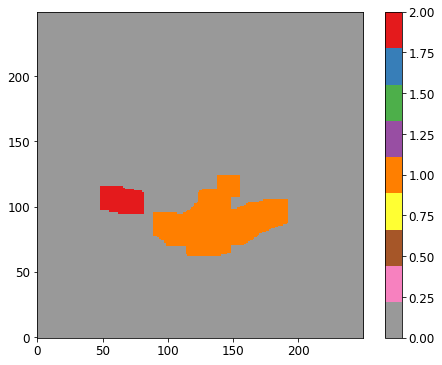

In [36]:
plt.figure(figsize=(8,6))
plt.imshow(SDlabels,origin='lower',cmap='Set1_r')
plt.colorbar()
plt.show()

#### Light Curves Map Plotting 

In [37]:
lcmap1,lcmap2,lcmap3,lcmap4,lcmap5,lcmap6,lcmap7,lcmap8,lcmap9 = [],[],[],[],[],[],[],[],[] 
for m in maps:
    lcmap1.append((m.data * (labels == 1)).sum())
    lcmap2.append((m.data * (labels == 2)).sum())
    lcmap3.append((m.data * (labels == 3)).sum())
    lcmap4.append((m.data * (labels == 4)).sum())
    lcmap5.append((m.data * (labels == 5)).sum())
    lcmap6.append((m.data * (labels == 6)).sum())
    lcmap7.append((m.data * (labels == 7)).sum())
    lcmap8.append((m.data * (labels == 8)).sum())
    lcmap9.append((m.data * (labels == 9)).sum())

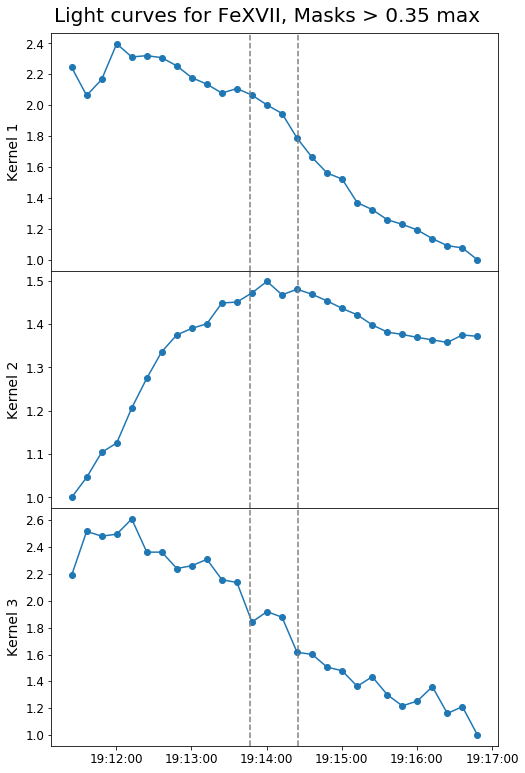

In [38]:
xfmt = md.DateFormatter('%H:%M:%S')
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True,figsize=(8,12))
fig.suptitle('Light curves for FeXVII, Masks > '+str(MaskRatio)+' max',fontsize=20);fig.subplots_adjust(top=0.95)
ax1.plot(atime,np.abs(lcmap1)/np.abs(min(lcmap1)),'o-')
ax1.axvline(x=atmax[0],linestyle='--',color='grey');ax1.axvline(x=atmax[1],linestyle='--',color='grey')
ax1.set_ylabel('Kernel 1')
ax1.xaxis.set_major_formatter(xfmt)
ax2.plot(atime,np.abs(lcmap2)/np.abs(min(lcmap2)),'o-')
ax2.axvline(x=atmax[0],linestyle='--',color='grey');ax2.axvline(x=atmax[1],linestyle='--',color='grey')
ax2.set_ylabel('Kernel 2')
ax3.plot(atime,np.abs(lcmap3)/np.abs(min(lcmap3)),'o-')
ax3.axvline(x=atmax[0],linestyle='--',color='grey');ax3.axvline(x=atmax[1],linestyle='--',color='grey')
ax3.set_ylabel('Kernel 3')
'''
ax4.plot(atime,np.abs(lcmap4)/np.abs(min(lcmap4)),'o-')
ax4.axvline(x=atmax[0],linestyle='--',color='grey');ax4.axvline(x=atmax[1],linestyle='--',color='grey')
ax4.set_ylabel('Kernel 4')
ax5.plot(atime,np.abs(lcmap5)/np.abs(min(lcmap5)),'o-')
ax5.axvline(x=atmax[0],linestyle='--',color='grey');ax5.axvline(x=atmax[1],linestyle='--',color='grey')
ax5.set_ylabel('Kernel 5')
ax6.plot(atime,np.abs(lcmap6)/np.abs(min(lcmap6)),'o-')
ax6.axvline(x=atmax[0],linestyle='--',color='grey');ax6.axvline(x=atmax[1],linestyle='--',color='grey')
ax6.set_ylabel('Kernel 6')
ax7.plot(atime,np.abs(lcmap7)/np.abs(min(lcmap7)),'o-')
ax7.axvline(x=atmax[0],linestyle='--',color='grey');ax7.axvline(x=atmax[1],linestyle='--',color='grey')
ax7.set_ylabel('Kernel 7')
ax8.plot(atime,np.abs(lcmap8)/np.abs(min(lcmap8)),'o-')
ax8.axvline(x=atmax[0],linestyle='--',color='grey');ax8.axvline(x=atmax[1],linestyle='--',color='grey')
ax8.set_ylabel('Kernel 8')
ax9.plot(atime,np.abs(lcmap9)/np.abs(min(lcmap9)),'o-')
ax9.axvline(x=atmax[0],linestyle='--',color='grey');ax9.axvline(x=atmax[1],linestyle='--',color='grey')
ax9.set_ylabel('Kernel 9')
'''
ax3.xaxis.set_major_formatter(xfmt)
fig.subplots_adjust(hspace=0)
plt.show()

In [39]:
print('Area Region-1 [pxs] =  '+str(len(labels[labels == 1])))
print('Area Region-2 [pxs] =  '+str(len(labels[labels == 2])))
print('Area Region-3 [pxs] =  '+str(len(labels[labels == 3])))
print('Area Region-4 [pxs] =  '+str(len(labels[labels == 4])))
print('Area Region-5 [pxs] =  '+str(len(labels[labels == 5])))
print('Area Region-6 [pxs] =  '+str(len(labels[labels == 6])))
print('Area Region-7 [pxs] =  '+str(len(labels[labels == 7])))
print('Area Region-8 [pxs] =  '+str(len(labels[labels == 8])))
print('Area Region-9 [pxs] =  '+str(len(labels[labels == 9])))

Area Region-1 [pxs] =  449
Area Region-2 [pxs] =  1019
Area Region-3 [pxs] =  21
Area Region-4 [pxs] =  36
Area Region-5 [pxs] =  29
Area Region-6 [pxs] =  52
Area Region-7 [pxs] =  0
Area Region-8 [pxs] =  0
Area Region-9 [pxs] =  0


### Light Curves [Maximun in FeXVIII Standard Deviation]

AttributeError: 'numpy.ndarray' object has no attribute 'autoscale_None'

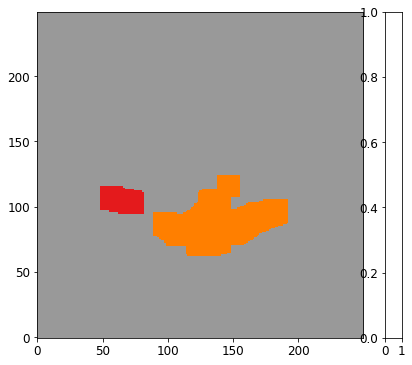

In [40]:
''' Kernels Visualization '''
plt.figure(figsize=(8,6))
plt.imshow(SDlabels,origin='lower',cmap='Set1_r')
plt.colorbar(SDlabels)
plt.show()

In [ ]:
lcsd1,lcsd2,lcsd3,lcsd4 = [],[],[],[]
for m in maps:
    lcsd1.append((m.data * (SDlabels == 1)).sum())
    lcsd2.append((m.data * (SDlabels == 2)).sum())
    lcsd3.append((m.data * (SDlabels == 3)).sum())
    lcsd4.append((m.data * (SDlabels == 4)).sum())

#### Light Curve Standard Deviation Plotting

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True,figsize=(8,9))
fig.suptitle('Light curves for FeXVII Stand. Dev., Masks > '+str(MaskRatio)+' max',fontsize=18);fig.subplots_adjust(top=0.95)
ax1.plot(atime,np.abs(lcsd1)/np.abs(min(lcsd1)),'go-')
ax1.axvline(x=atmax[0],linestyle='--',color='grey');ax1.axvline(x=atmax[1],linestyle='--',color='grey')
ax1.set_ylabel('Kernel 1')
ax2.plot(atime,np.abs(lcsd2)/np.abs(min(lcsd2)),'go-')
ax2.axvline(x=atmax[0],linestyle='--',color='grey');ax2.axvline(x=atmax[1],linestyle='--',color='grey')
ax2.set_ylabel('Kernel 2')
ax3.plot(atime,np.abs(lcsd3)/np.abs(min(lcsd3)),'go-')
ax3.axvline(x=atmax[0],linestyle='--',color='grey');ax3.axvline(x=atmax[1],linestyle='--',color='grey')
ax3.set_ylabel('Kernel 3')
#ax4.plot(atime,np.abs(lcsd4)/np.abs(min(lcsd4)),'go-')
#ax4.axvline(x=atmax[0],linestyle='--',color='grey');ax4.axvline(x=atmax[1],linestyle='--',color='grey')
#ax4.set_ylabel('Kernel 4')
ax3.xaxis.set_major_formatter(xfmt)
fig.subplots_adjust(hspace=0)
plt.show()

In [ ]:
print('Area Region-1 [pxs] =  '+str(len(SDlabels[SDlabels == 1])))
print('Area Region-2 [pxs] =  '+str(len(SDlabels[SDlabels == 2])))
print('Area Region-3 [pxs] =  '+str(len(SDlabels[SDlabels == 3])))
print('Area Region-4 [pxs] =  '+str(len(SDlabels[SDlabels == 4])))

## Save fits file

In [ ]:
from astropy.io import fits

In [ ]:
fits.writeto('/Users/Kamilobu/Desktop/test1.fits', SDlabels,overwrite=True)

## Kobelski, McKenzie and Donachie [2014] Method: 

In [ ]:
def mean(cmaps):
    """
    Calculate the average of the data array.
    """
    _meta = []
    for i, m in enumerate(cmaps):
        _meta.append(m.meta)
    data = np.zeros((cmaps[0].data.shape[0], cmaps[0].data.shape[1], len(cmaps)), dtype=cmaps[0].data.dtype)
    for i, m in enumerate(cmaps):
        data[:, :, i] = m.data
    return Map(np.mean(data, axis=2), _meta[1])

def get_neighbours2(data, cell):
    """Find the neighbouring values for the cell in the 'data' list
           data : A homogenous 2d list (i.e. all rows are the same length)
       cell : A 2-tuple with row, column in order
    """
    neighbours = []
    row, col = cell[0], cell[1]
    row_max = len(data) # Get upper bound of row length
    col_max = len(data[0])
 
    return [data[row_d + row][col_d + col]
    for col_d in [-1,0,1]
        if (0 <= (col_d + col) < col_max) or (col_d == 0 and row_d==0)
    for row_d in [-1,0,1]
    if 0 <= (row_d + row) < row_max ]

Making `maps`, `bright_maps`, `maps_qd`, and `maps_qc` for IRIS observation:

In [ ]:
wrm = 44 # (int) time width - 44 frames is equivalent to 10 min
qd = 4
qc = 3
smap,bright_maps,maps_qd,maps_qc = [],[],[],[]

for i in range(53,173):
    maps_i = maps[i-wrm//2:i+wrm//2]   # Takes wrm 'frames' around frame i
    mean_i = mean(maps_i) # Calculates the mean around i
    residual_i = (maps[i].data - mean_i.data) # residual data
    std_i = std(maps[i-wrm//2:i+wrm//2]).data # STD 
    data_qd = (residual_i/std_i)
    data_qd[np.where((residual_i/std_i)<=qd)] = 0.0 # Data under QD TH
    data_qc = (residual_i/std_i)
    data_qc[np.where((residual_i/std_i)<=qc)] = 0.0 # Data under QC TH
    smap.append(maps[i])
    maps_qd.append(Map(data_qd, mean_i.meta))
    maps_qc.append(Map(data_qc, mean_i.meta))
    bright_maps.append(Map(residual_i/std_i, mean_i.meta))

### Plotting one of the maps with the qd and qc parameters as an example

In [ ]:
i = 32 
%matplotlib inline
'''Plotting'''
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
maps[i].plot(title='Raw data')
plt.colorbar()
plt.subplot(2,2,2)
bright_maps[i].plot(vmin=0.01, title='residual vs std ratio')
plt.colorbar()
plt.subplot(2,2,3)
maps_qd[i].plot(title='residual vs std ratio over qd')
plt.colorbar()
plt.subplot(2,2,4)
maps_qc[i].plot(title='residual vs std ratio over qc')
plt.colorbar()
plt.show()